<a href="https://colab.research.google.com/github/slvrsrfrrr/Machine-Learning/blob/main/LSTM_Time_Series_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [ ]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
df.dtypes

Date Time           object
p (mbar)           float64
T (degC)           float64
Tpot (K)           float64
Tdew (degC)        float64
rh (%)             float64
VPmax (mbar)       float64
VPact (mbar)       float64
VPdef (mbar)       float64
sh (g/kg)          float64
H2OC (mmol/mol)    float64
rho (g/m**3)       float64
wv (m/s)           float64
max. wv (m/s)      float64
wd (deg)           float64
dtype: object

In [ ]:
df = df[5::6]
#this means from the fifth interval, take every 6th value. the data we have is for every 10 minutes and we've got it to one entry per hour now.

In [ ]:
df.index = pd.to_datetime(df['Date Time'],format ='%d.%m.%Y %H:%M:%S')
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 01:00:00,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


**temperature Over Time**

<Axes: xlabel='Date Time'>

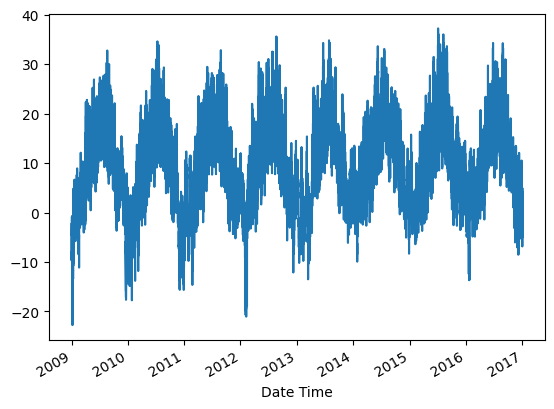

In [ ]:
temp = df['T (degC)']
temp.plot()

we want to put the data into some kind of matrix. to explain, imagine you have the temperature over 5 hours and you want to predict the tempurature over the next hour. to get the next hour after that, youd basically bump the 5 initial values up by 1 and make the next prediction.
so that would look like


---

x= [[1][2][3][4][5]]  y=[[6]


---


   [[2][3][4][5][6]]    [[7]

each of the entries in the input matrix are also a list. it could be temp, pressure etc

In [ ]:
def df_to_X_y(df,window_size=5):
  df_as_numpy = df.to_numpy()
  X=[]
  y=[]
  for i in range(len(df_as_numpy)-window_size):
    row = [[a] for a in df_as_numpy[i:i+window_size]]
    X.append(row)
    label = df_as_numpy[i+window_size]
    y.append(label)
  return np.array(X),np.array(y)

In [ ]:
window_sizee = 5
X,y = df_to_X_y(temp,window_sizee)
X.shape,y.shape

((70086, 5, 1), (70086,))

***Train, Test, Validation Split***

In [ ]:
X_train,y_train=X[:60000],y[:60000]
X_test,y_test=X[60000:65000],y[60000:65000]
X_val,y_val=X[65000:],y[65000:]


In [11]:
from tensorflow.keras import models

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [17]:
model1= Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate=0.0001),metrics=[RootMeanSquaredError()])

In [19]:
model1.fit(X_train,y_train,validation_data=(X_val,y_val),epochs=10,callbacks=[cp])

Epoch 1/10
1875/1875 [==============================] - 19s 9ms/step - loss: 28.5202 - root_mean_squared_error: 5.3404 - val_loss: 3.8384 - val_root_mean_squared_error: 1.9592
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 1.6446 - root_mean_squared_error: 1.2824 - val_loss: 1.1238 - val_root_mean_squared_error: 1.0601
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.8763 - root_mean_squared_error: 0.9361 - val_loss: 0.8076 - val_root_mean_squared_error: 0.8987
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.7299 - root_mean_squared_error: 0.8544 - val_loss: 0.6841 - val_root_mean_squared_error: 0.8271
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6847 - root_mean_squared_error: 0.8275 - val_loss: 0.6567 - val_root_mean_squared_error: 0.8103
Epoch 6/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.6686 - root_mean_squared_error: 0.8177 - val_

In [20]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [21]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train})
train_results

1875/1875 [==============================] - 6s 3ms/step


,Train Predictions,Actuals
0,-9.654012,-9.67
1,-9.394166,-9.17
2,-8.454165,-8.10
3,-6.966276,-7.66
4,-6.953986,-7.04
...,...,...
59995,5.940444,6.07
59996,7.297068,9.88
59997,12.421200,13.53
59998,16.361366,15.43


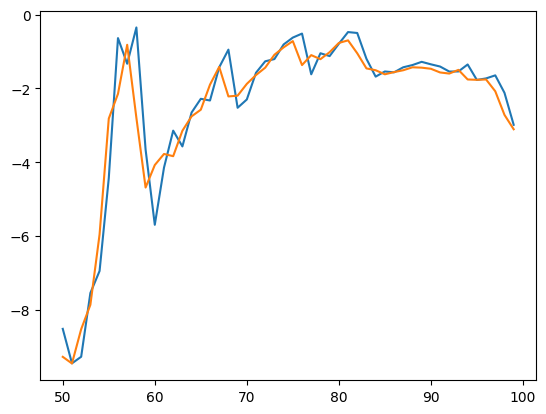

In [22]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

159/159 [==============================] - 1s 3ms/step


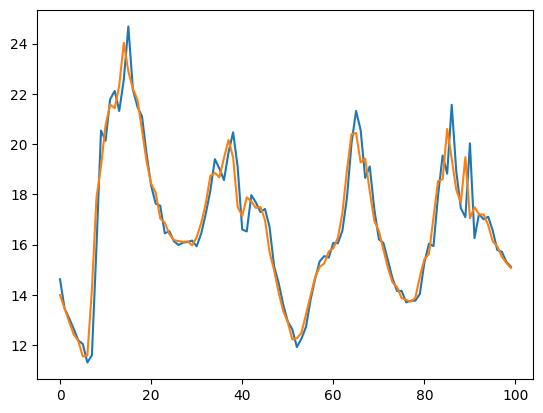

In [23]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val})
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

157/157 [==============================] - 1s 4ms/step


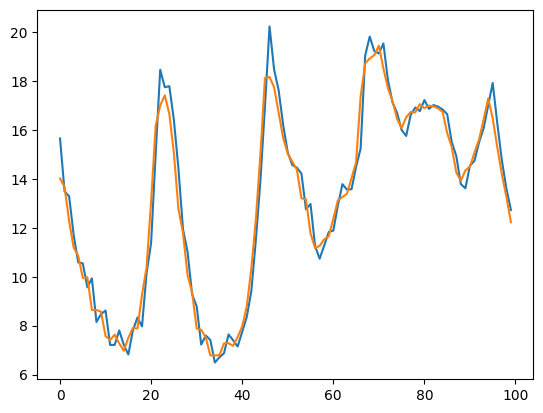

In [24]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test})
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])